# Select features on stock returns

This notebook exemplifies how to select features by linear regression.

### Step 1: Add base features
We include $\beta_{i, t}$ and the additional features in linear regression. Specifically, since we are working on return_based_features, we add the following return-based features:

(1) return_avg_5d: 5-day rolling average of return, $r^{avg, 5d}_{i, t} = \frac{1}{5}\sum_{j=0}^{4} r_{i, t-j}$

(2) return_avg_20d: 20-day rolling average of return, $r^{avg, 20d}_{i, t} = \frac{1}{20}\sum_{j=0}^{19} r_{i, t-j}$

(3) return_avg_120d: 120-day rolling average of return, $r^{avg, 120d}_{i, t} = \frac{1}{120}\sum_{j=0}^{119} r_{i, t-j}$

(4) return_skewness_60d: 60-day rolling skewness of return, $r^{skew, 60d}_{i, t} = \frac{1}{60}\sum_{j=0}^{59} (r_{i, t-j} - \bar{r}_{i, t})^3$

(5) return_kurtosis_60d: 60-day rolling kurtosis of return, $r^{kurt, 60d}_{i, t} = \frac{1}{60}\sum_{j=0}^{59} (r_{i, t-j} - \bar{r}_{i, t})^4$

(6) return_mean_revert_20d: 20-day rolling mean reversion of return, $s_{i, t} = \frac{r_{i, t} - \bar{r}_i}{\sigma_i} \implies r^{MR}_{i, t} = \sum_{j=0}^{19} s_{i, t-j}$, where $\bar{r}_i$ and $\sigma_i$ are the mean and standard deviation of $r_{i, t}$ over the past 120 days.

We start with the linear regression model:

$$ \beta^F_{i, t} \sim \beta_{i, t} + r^{avg, 5d}_{i, t} + r^{avg, 20d}_{i, t} + r^{avg, 120d}_{i, t} + r^{skew, 60d}_{i, t} + r^{kurt, 60d}_{i, t} + r^{MR}_{i, t}$$

**We remove those features with high p-value for t-statistics and low correlation (low variance inflation factor) to other features in the linear regression model.** The VIF is defined as $\text{VIF}_i = \frac{1}{1 - R^2_i}$, where $R^2_i$ is the coefficient of determination of the regression of feature $i$ on all other features. A VIF value greater than 10 indicates high correlation between features.


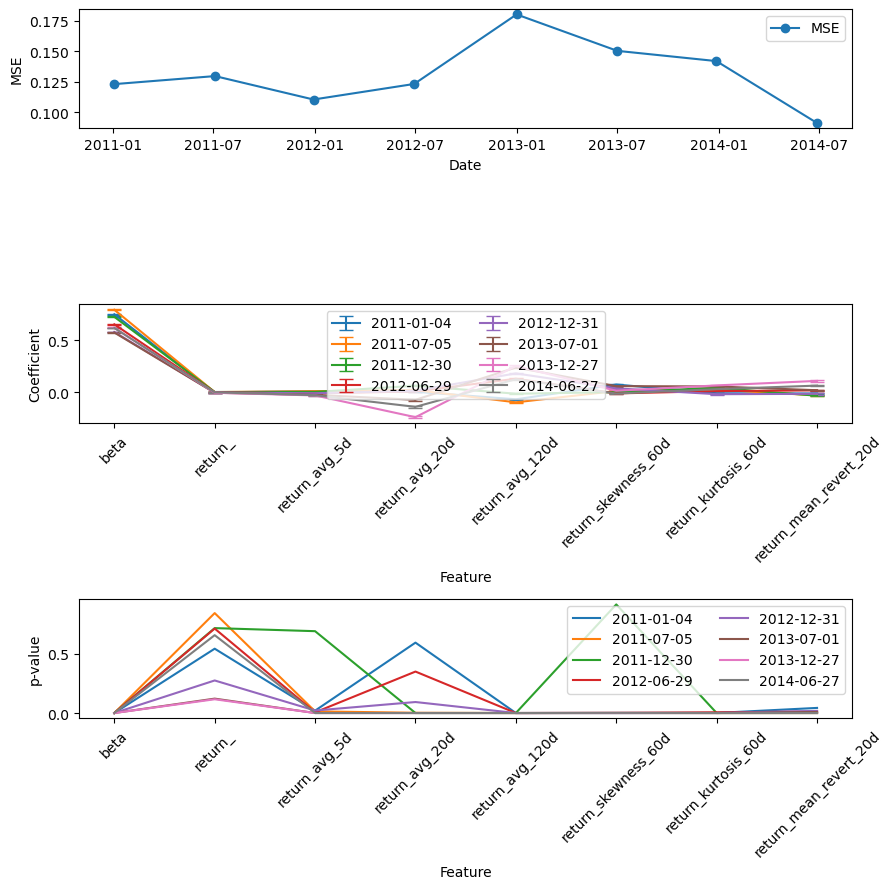

In [1]:
import os, sys, copy, scipy, datetime, tqdm, collections, itertools, pickle
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

if __name__ == "__main__":
    sys.path.append(os.path.join(os.getcwd(), '..'))
import utils

file_name = os.path.join(os.getcwd(), "../data/data_transformed.npz")
data = np.load(file_name, allow_pickle=True)
code_list = data["code_list"].tolist(); ticker_list = data["ticker_list"].tolist(); time_axis = data["time_axis"].tolist()
adjclose = data["adjclose"]; volume = data["volume"]; return_ = data["return_"]
beta = data["beta"]; forward_beta = data["forward_beta"]
SPY_adjclose = data["SPY_adjclose"]; SPY_volume = data["SPY_volume"]; SPY_return = data["SPY_return"]
N = len(code_list); T = len(time_axis)

file_name = os.path.join(os.getcwd(), "../data/feature_dict.pkl")
with open(file_name, "rb") as f:
    feature_dict = pickle.load(f)

feature_pool = ["beta", 
                  "return_", "return_avg_5d", "return_avg_20d", "return_avg_120d", 
                  "return_skewness_60d", "return_kurtosis_60d", "return_mean_revert_20d"]

mse_model_initial = utils.feature_selection_MSE(feature_pool)


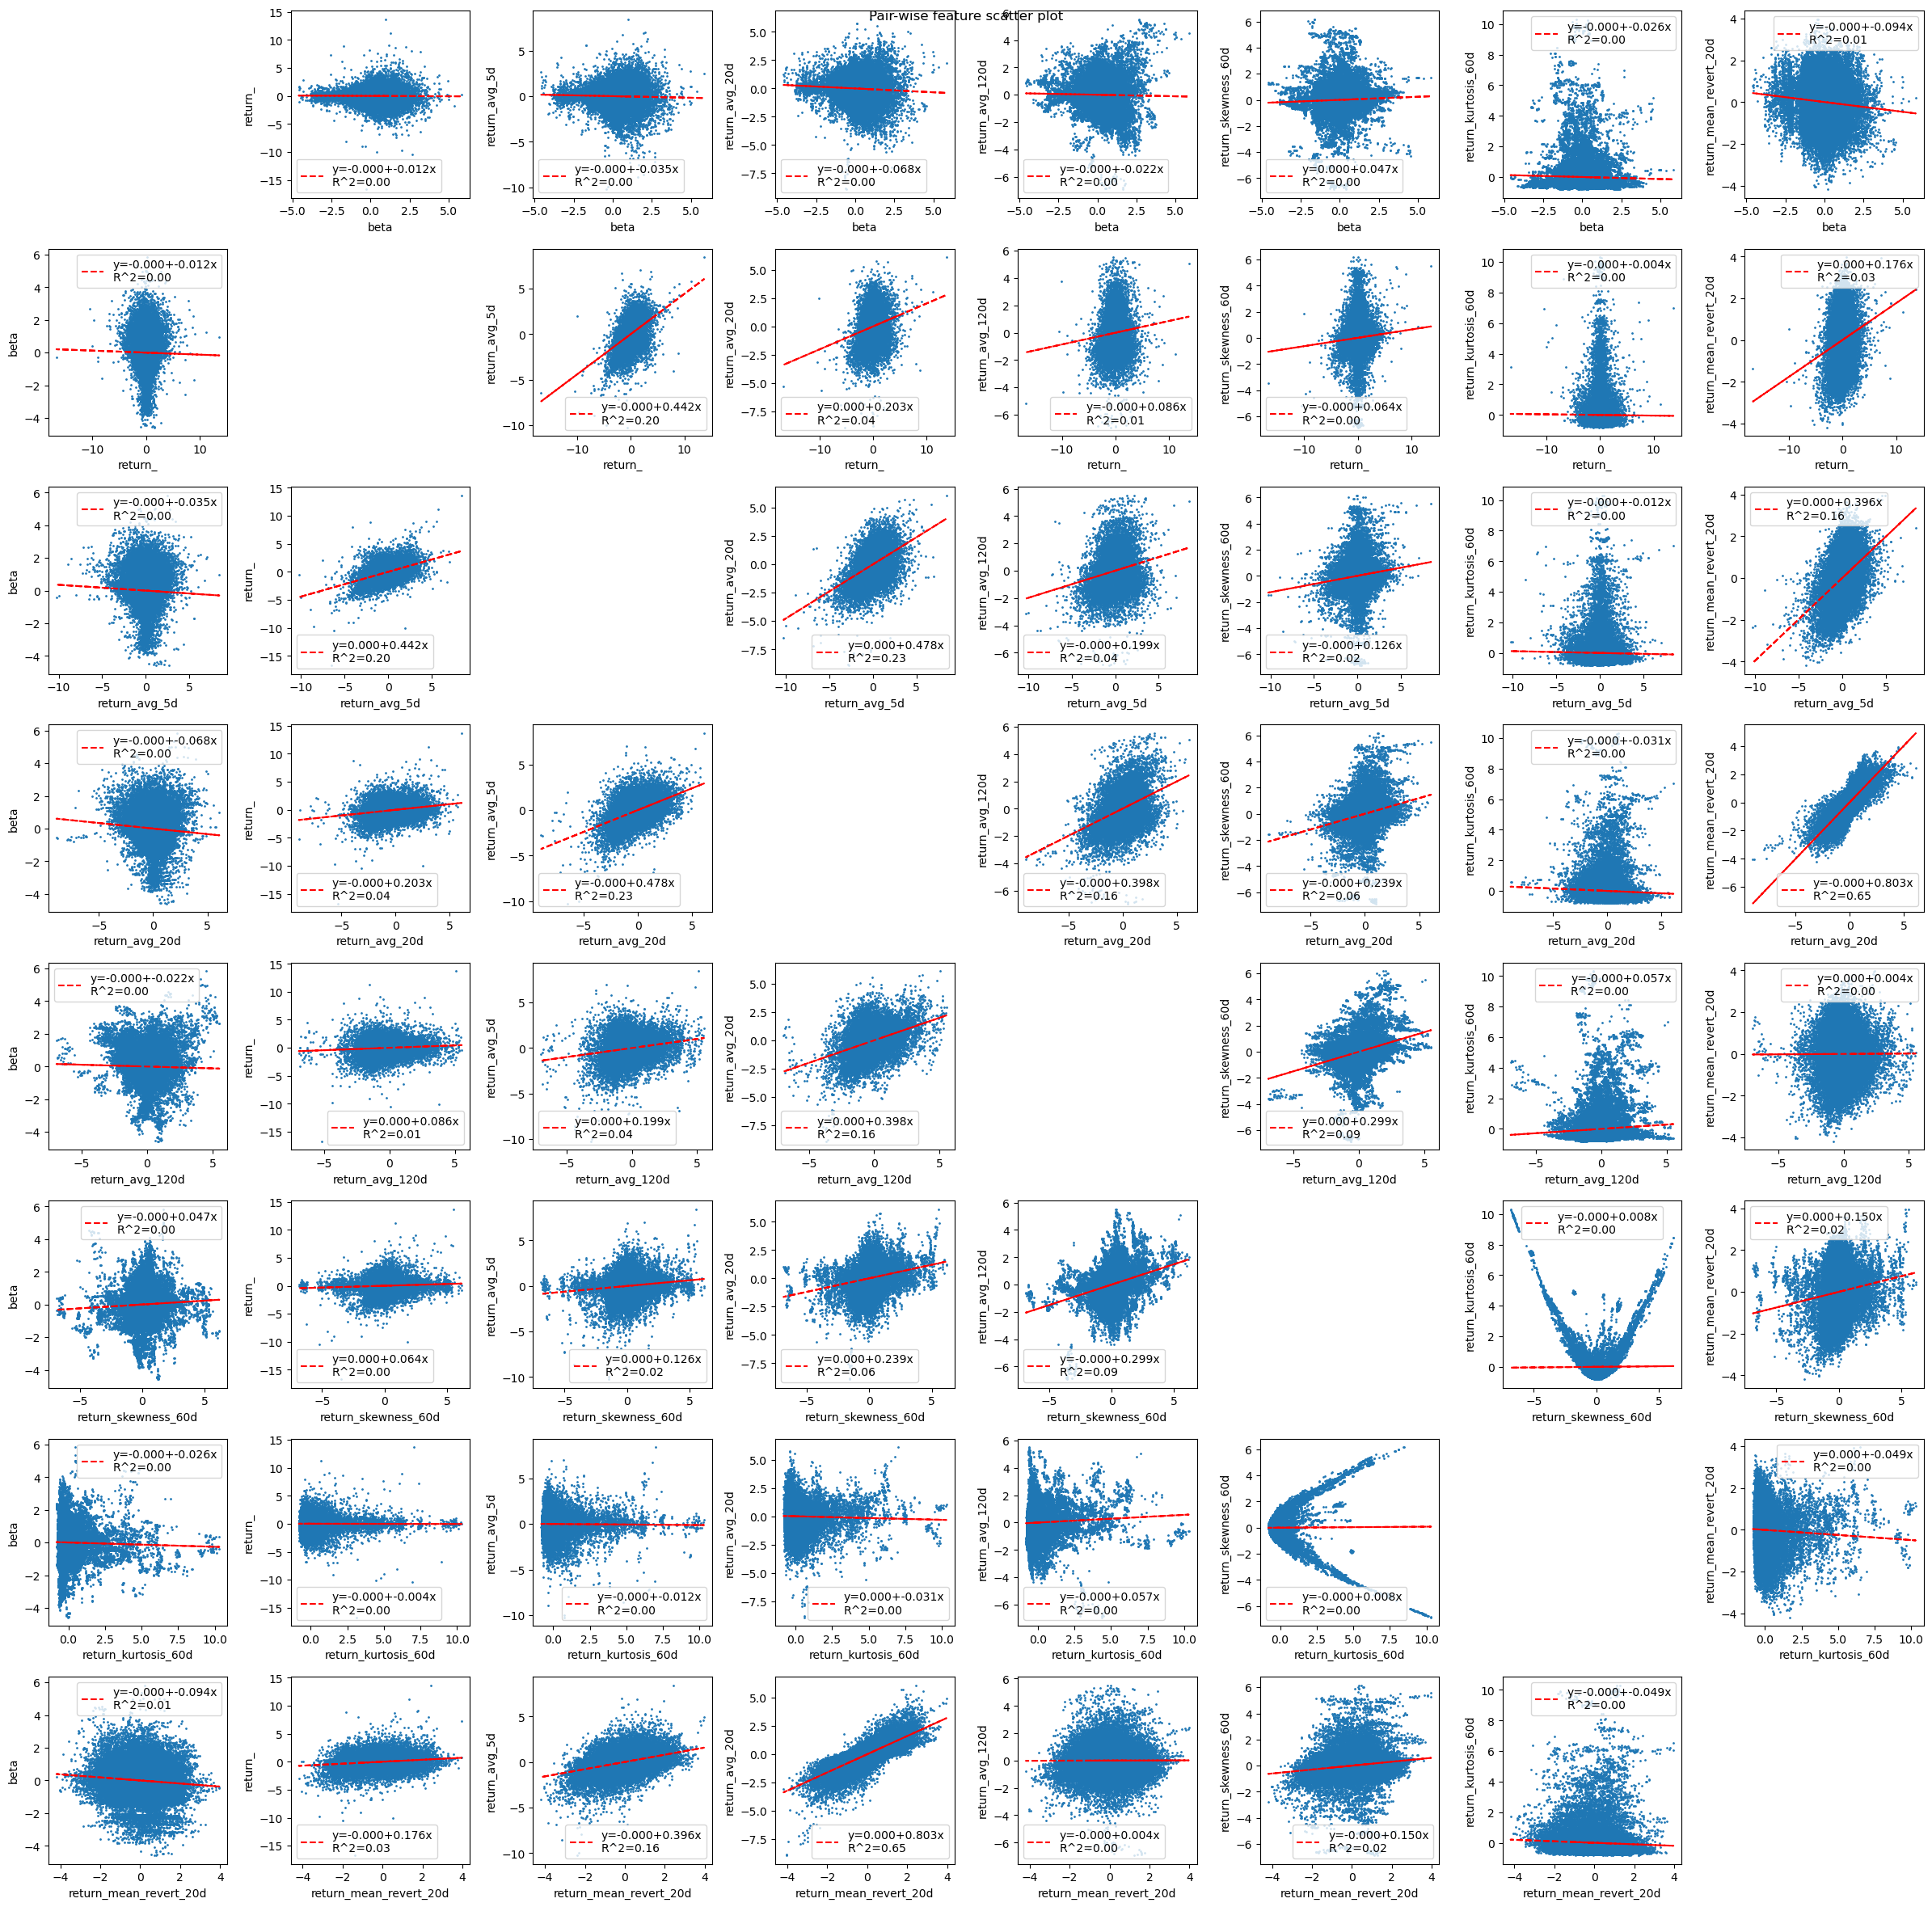

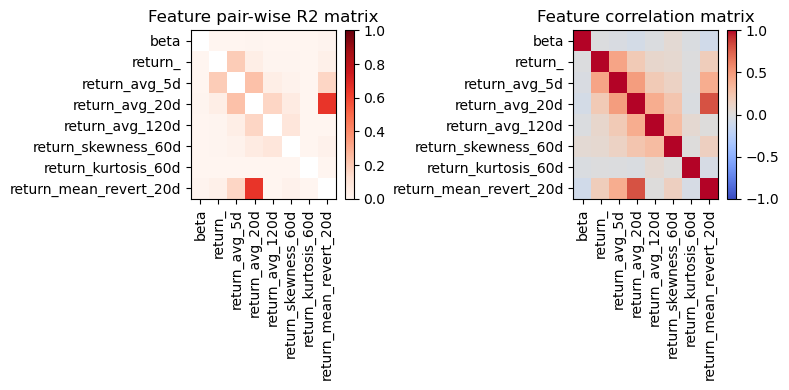

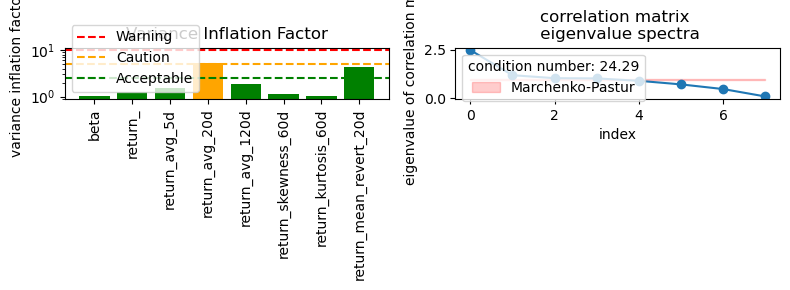

In [2]:
model = utils.linear_model_diagnosis(feature_pool, year=2012, colinearity=True)
#model = utils.linear_model_diagnosis(feature_pool, year=2013, colinearity=True)
#model = utils.linear_model_diagnosis(feature_pool, year=2014, colinearity=True)
#model = utils.linear_model_diagnosis(feature_pool, year=2015, colinearity=True)

### Conclusion:
We remove feature ***return*** for its low t-statistic (i.e. high *p*-value) with low collinearity.


## Step 2: Add non-linear features
After removing non-significant features, we add the second-order polynomial and their interaction terms of the remaining features. Specifically, we compare the null model

$H_0: \quad Y \sim X_1 + X_2 + ... + X_p + \epsilon$

with the model

$ H_{i, j}:\quad  Y \sim X_1 + X_2 + ... + X_p + X_i*X_j + \epsilon, \quad \forall i=1,2,..., p, j = 1,2, ..., p$

We the following metric to evaluate model $H_{i, j}$:

(i) p-value F-statistic: $F = \frac{(R^2_{H_{i, j}} - R^2_{H_0}) / (p_{H_{i, j}} - p_{H_0})}{(1 - R^2_{H_{i, j}}) / (n - p_{H_{i, j}})}$

(ii) Akaike Information Criterion (AIC): $AIC = n \log(\frac{SSE}{n}) + 2p$

(iii) Bayesian Information Criterion (BIC): $BIC = n \log(\frac{SSE}{n}) + p \log(n)$

(iv) Cross-validation error: $\frac{\bar{\varepsilon^2}_{valid} - \bar{\varepsilon^2}_{train}}{\bar{\varepsilon^2}_{train}}$, where $\bar{\varepsilon^2}_{valid}$ and  $\bar{\varepsilon^2}_{train}$ are the mean squared errors of the validation and training set, respectively.

Since the homoscedasticity and normality assumption is not well satisfied (to show below), we mainly rely on the cross-validation $R^2$ complemented by the AIC and BIC to select the important feature.

To auxiliary the model comparison and check non-linearity, we also make the following plots:

(i) Residuals vs features: $\varepsilon_i^2 \sim X_i$, where $\varepsilon_i$ is the residual of the linear regression $H_0$.

(ii) partial residuals: $\varepsilon_i + a_i X_i \sim X_j$, where $a_i$ is the coefficient of feature $X_i$ in the linear regression $H_0$.

(iii) add variable plot: $r_y \sim r_{x_i}$, where $r_y$ is the residual of $Y \sim X_{-i}$ and $r_{x_i}$ is the residual of $X_i \sim X_{-i}$, where $X_{-i}$ is the set of all features except $X_i$.




RESET test statistic: 268.953, p-value: 0.0000


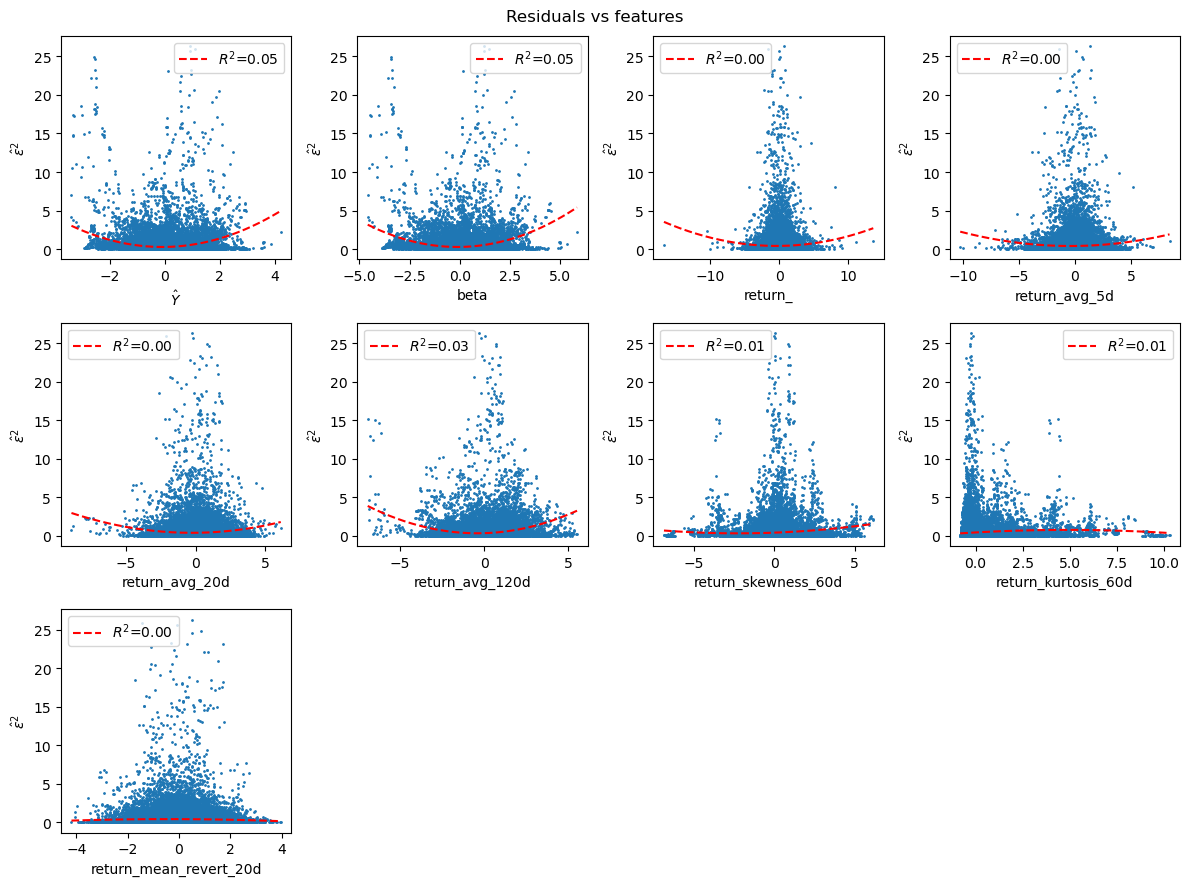

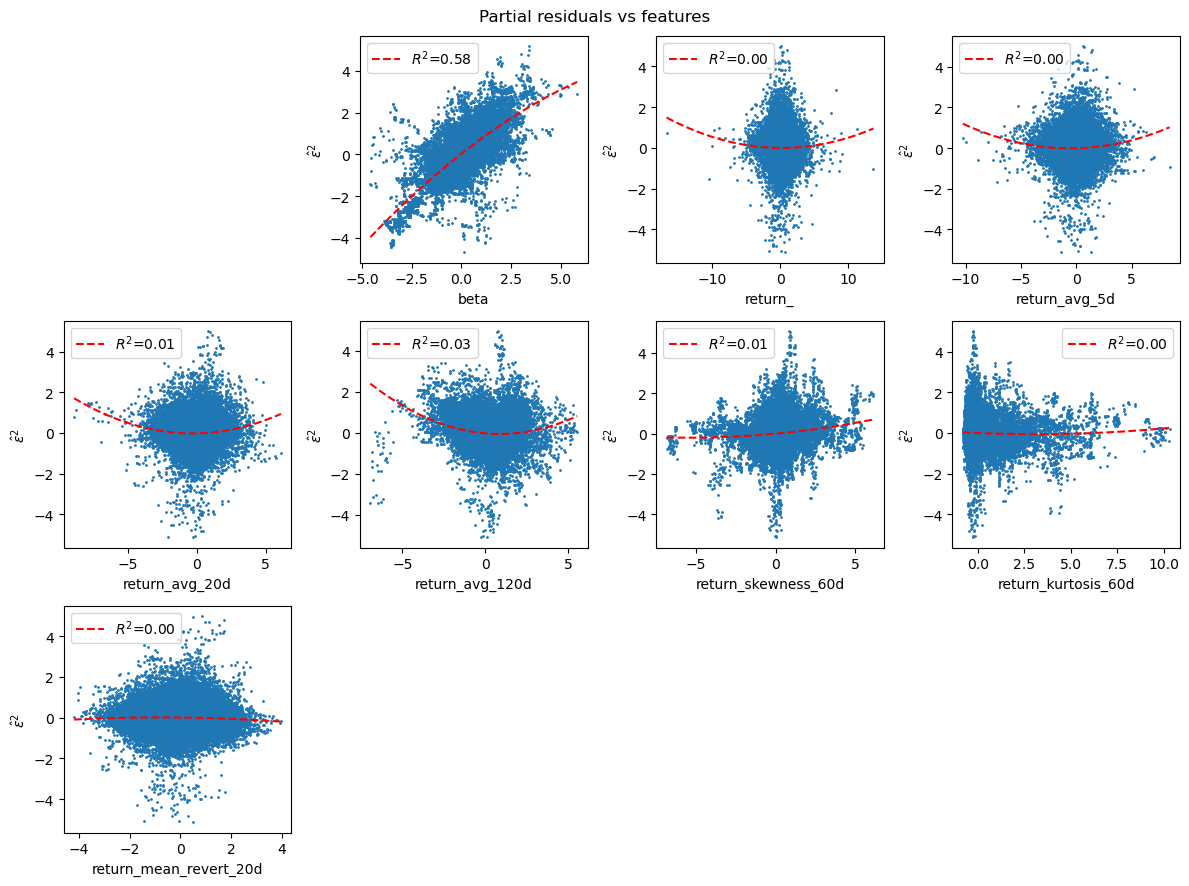

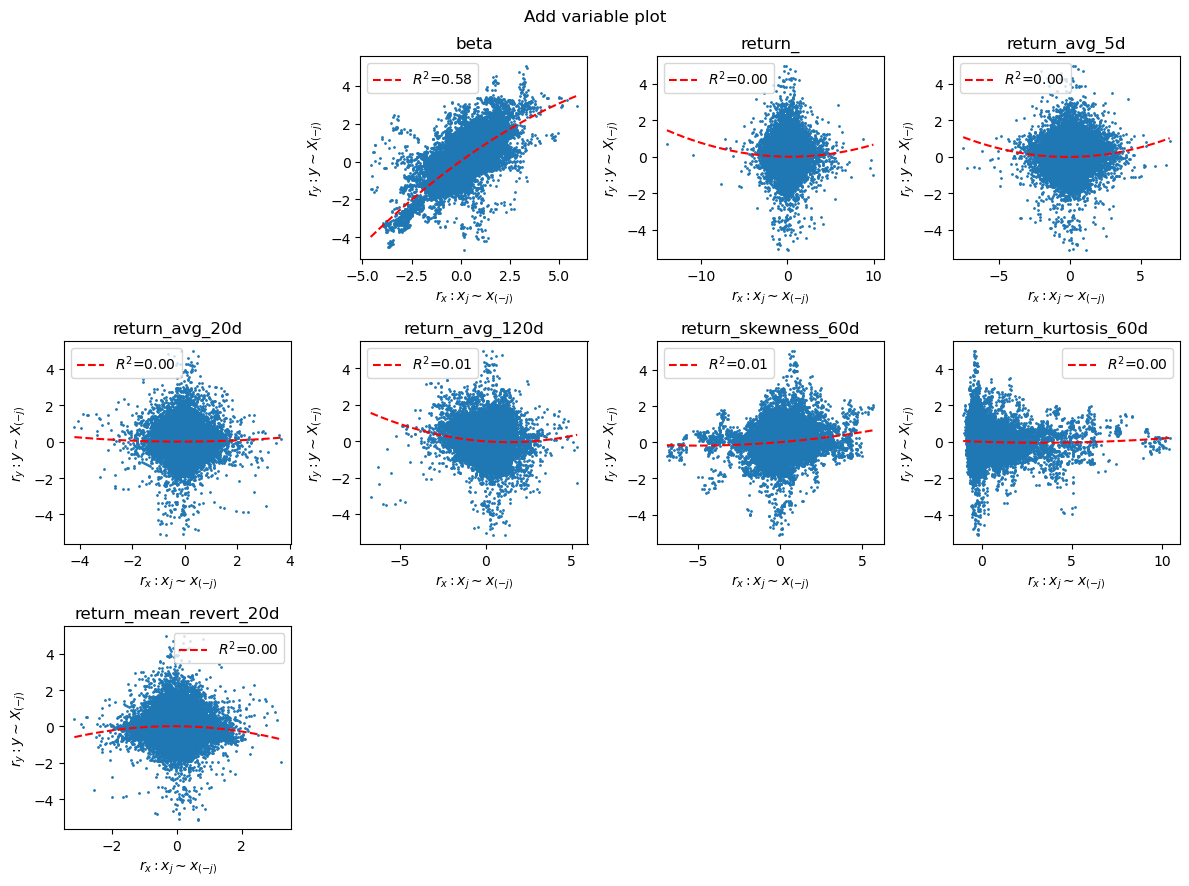

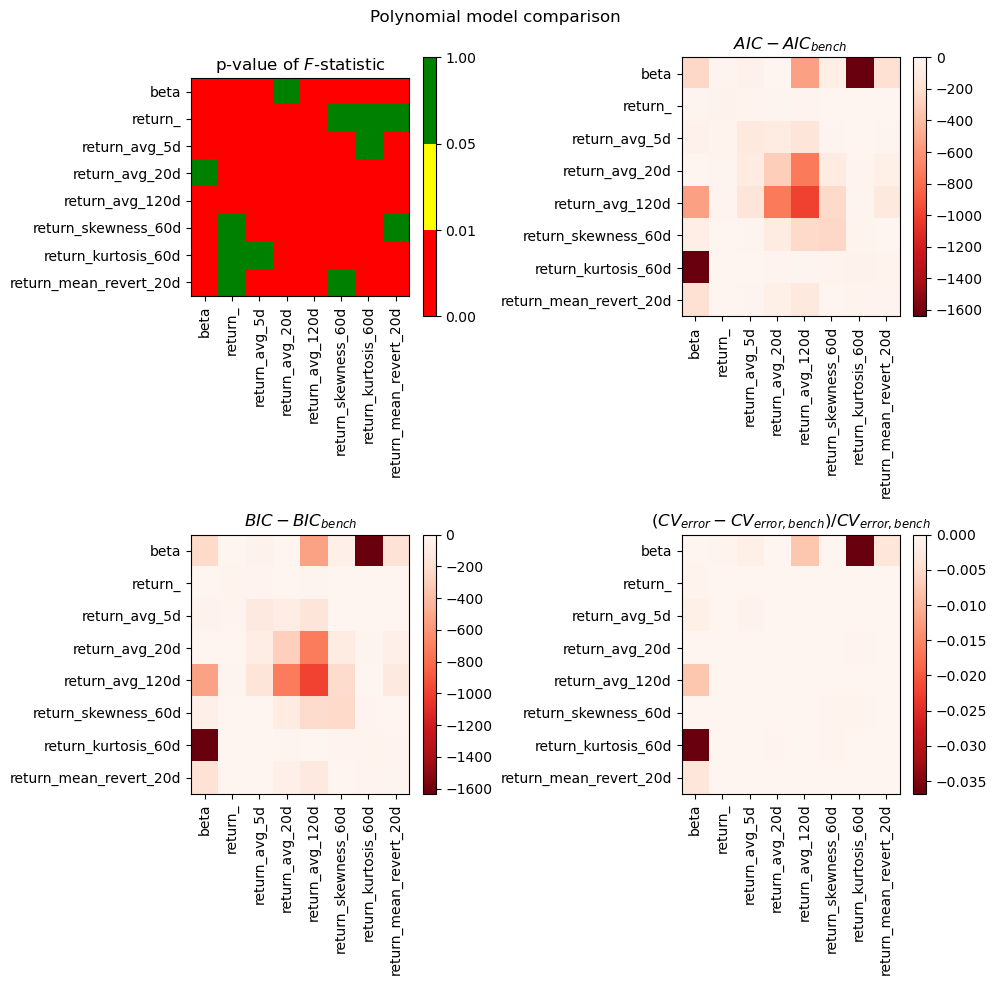

In [3]:
model = utils.linear_model_diagnosis(feature_pool, year=2012, nonlinearity=True)

RESET test statistic: 1331.040, p-value: 0.0000


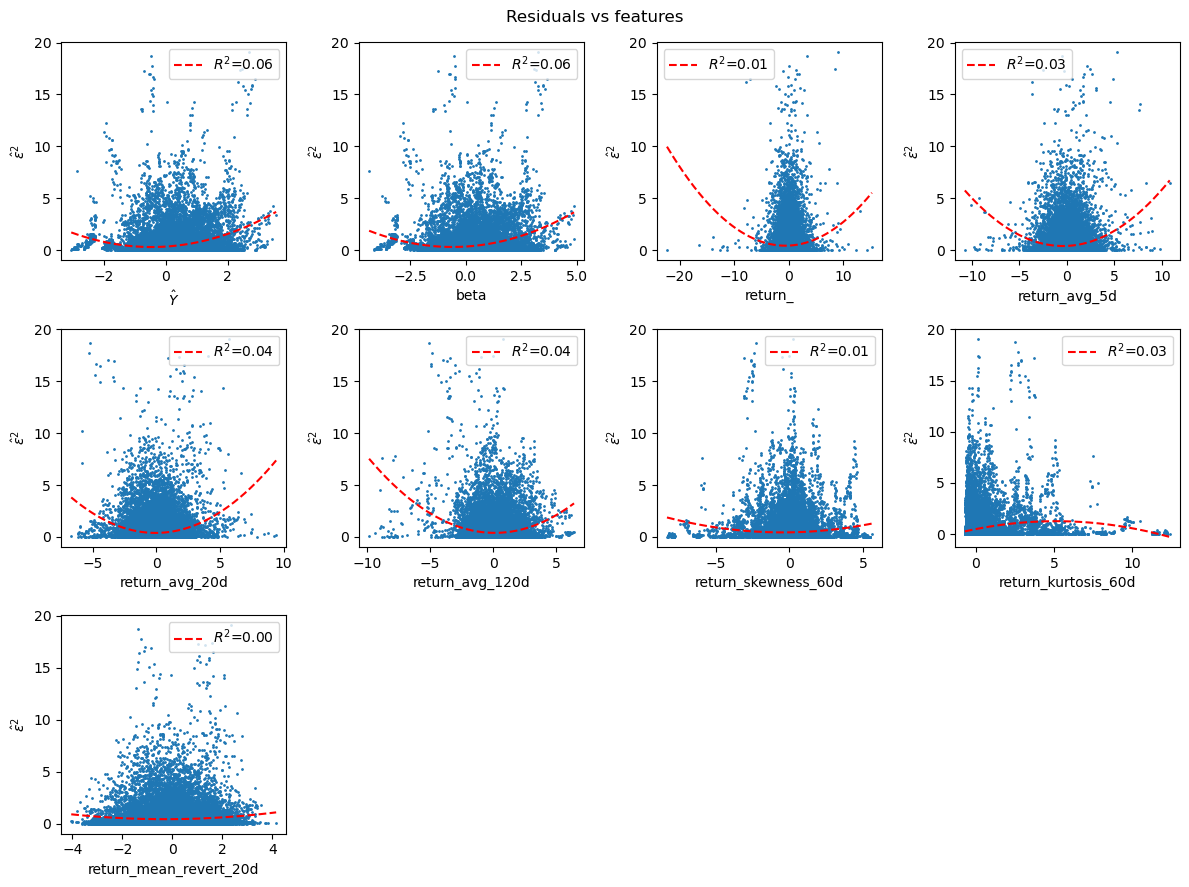

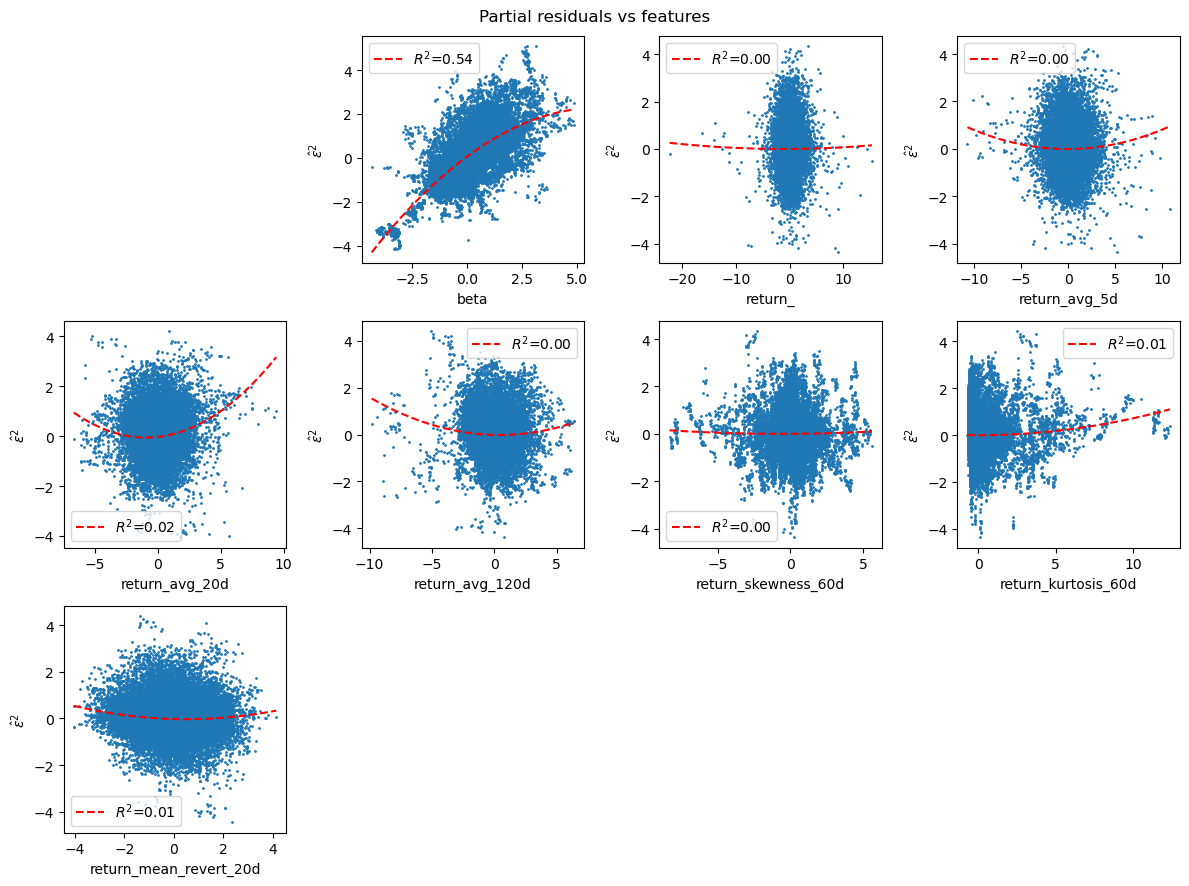

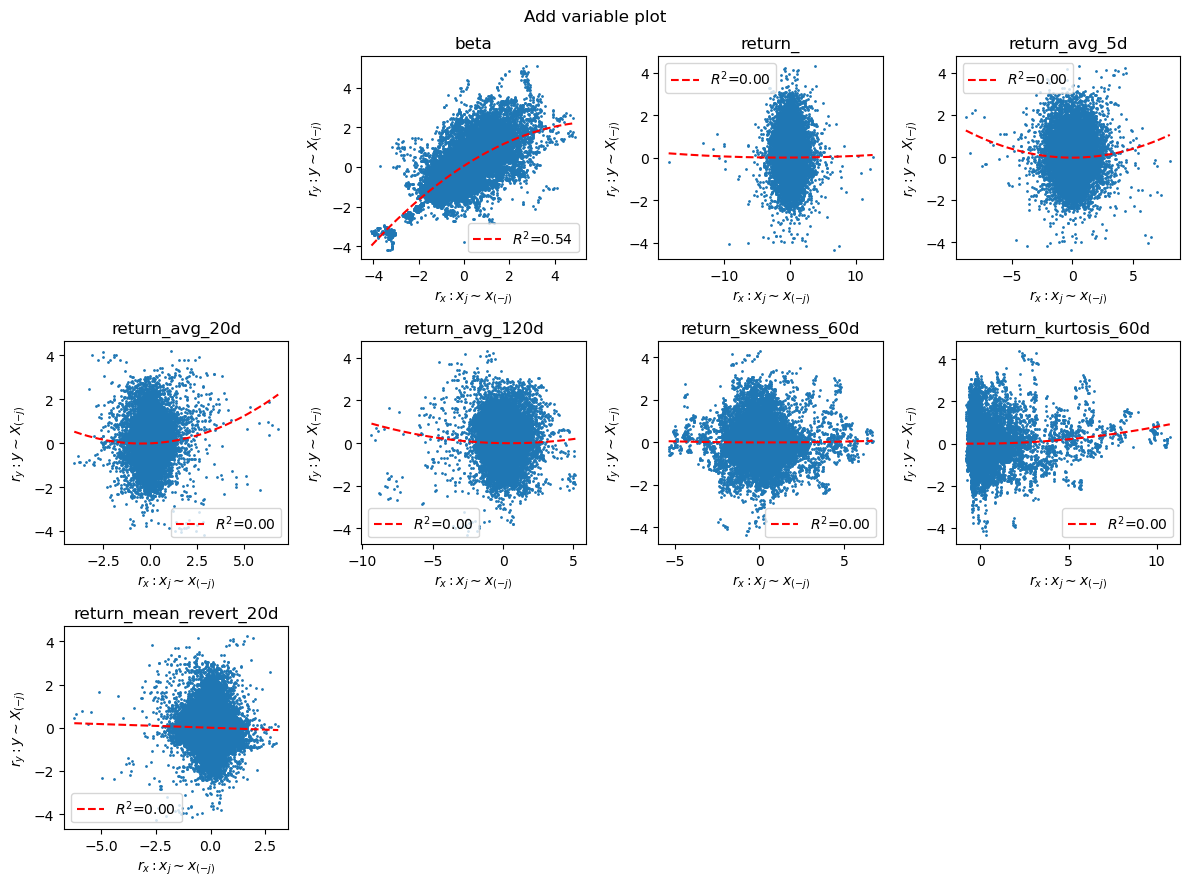

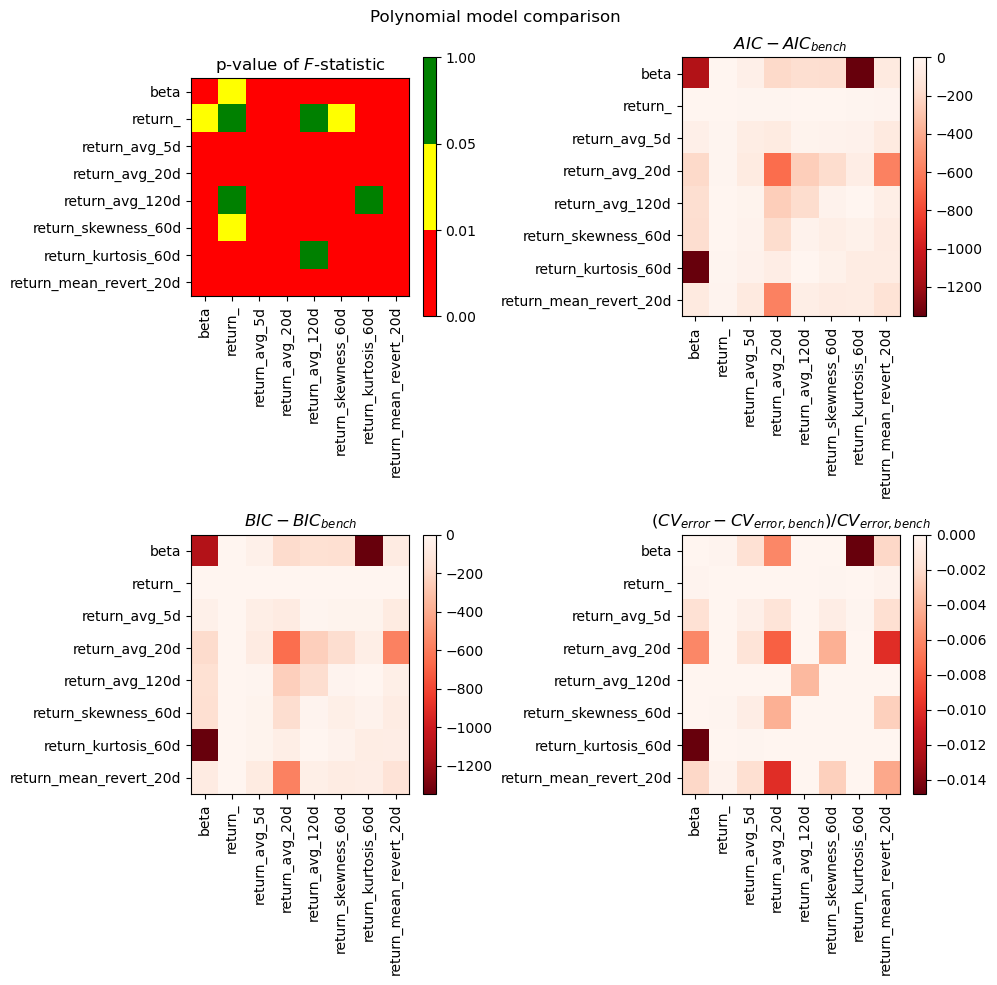

In [4]:
model = utils.linear_model_diagnosis(feature_pool, year=2013, nonlinearity=True)
#model = utils.linear_model_diagnosis(feature_pool, year=2014, nonlinearity=True)
#model = utils.linear_model_diagnosis(feature_pool, year=2015, nonlinearity=True)

### Conclusion
We add the following features to the model:
- return_kurtosis_60d*beta: $r^{kurt, 60d}_{i, t}*\beta_{i, t}$
- beta**2: $\beta_{i, t}^2$
- return_avg_120d**beta: $r^{avg, 120d}_{i, t}*\beta_{i, t}$

## Step 3: Select the features by importance
From the analysis in step 1 ad step 2, here are the features we have selected:
``` python
feature_column = ["beta", 
                  "return_avg_5d", "return_avg_20d", "return_avg_120d", 
                  "return_skewness_60d", "return_kurtosis_60d", "return_mean_revert_20d",
                  "return_kurtosis_60d*beta", "beta**2", "return_avg_120d**beta"]
```
, where the second and third row contains the return-based features, and the remaining rows are the non-linear features. We need to select features from the above list by their importance. We consider the following methods to select features:

(i) **Best subset selection**: We use the best subset selection method to select the features. Given a pre-specified number of features, the best subset selection method evaluates all possible combinations of features and selects the one with the CV error. This method is computationally expensive.

(ii) **Backward selection**: The backward selection method starts with all features and removes one feature at a time, selecting the feature that improves the model the most at each step. The process continues until no further improvement is possible. This is a greedy algorithm that may not be global optimal.

(iii) **Lasso regression**: The lasso regression method adds a penalty term to the linear regression model, which shrinks the coefficients of less important features towards zero.

(iv) **Least angle regression**: The least angle regression method is a modification of the lasso regression method that selects features in a stepwise manner. It starts with all features and adds one feature at a time, selecting the feature that improves the model the most at each step. The process continues until no further improvement is possible.

These four methods will select features given a pre-specified number of features. The optimal number of features is determined by maximizing the cross-validation $R^2$ on the validation set. Then, we assign one vote to the selected features by the method that yields the highest cross-validation $R^2$. We sum the number of votes for each feature for each calendar year.


--- Feature selection by best subset ---
feature_num: 0, best feature: [], R^2 (in-sample): -0.0000, AIC (in-sample): 116444.7718, BIC (in-sample): 116453.3939, R^2 (out-of-sample): -0.0007
feature_num: 1, best feature: [0], R^2 (in-sample): 0.5764, AIC (in-sample): 81200.0064, BIC (in-sample): 81217.2506, R^2 (out-of-sample): 0.6942
feature_num: 2, best feature: [0, 9], R^2 (in-sample): 0.5821, AIC (in-sample): 80652.4169, BIC (in-sample): 80678.2833, R^2 (out-of-sample): 0.7073
feature_num: 3, best feature: [0, 5, 7], R^2 (in-sample): 0.5914, AIC (in-sample): 79726.4852, BIC (in-sample): 79760.9737, R^2 (out-of-sample): 0.7151
feature_num: 4, best feature: [0, 5, 7, 9], R^2 (in-sample): 0.5962, AIC (in-sample): 79247.6631, BIC (in-sample): 79290.7737, R^2 (out-of-sample): 0.7249
feature_num: 5, best feature: [0, 4, 5, 7, 9], R^2 (in-sample): 0.6023, AIC (in-sample): 78616.6689, BIC (in-sample): 78668.4015, R^2 (out-of-sample): 0.7302
feature_num: 6, best feature: [0, 4, 5, 6, 7, 9], 

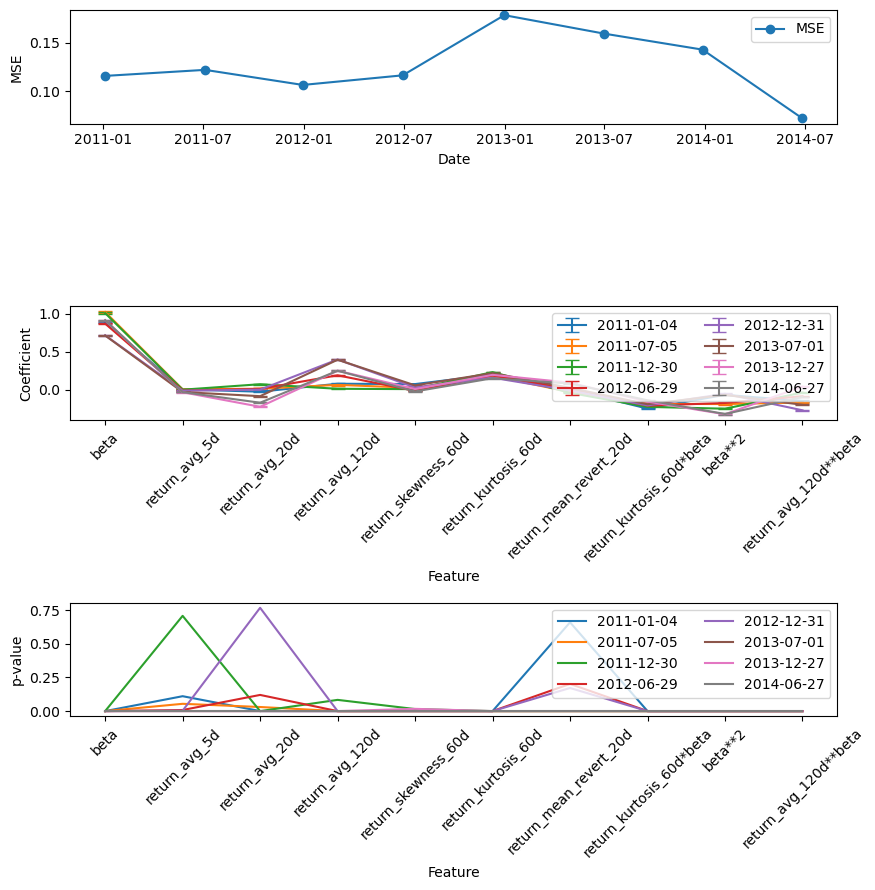

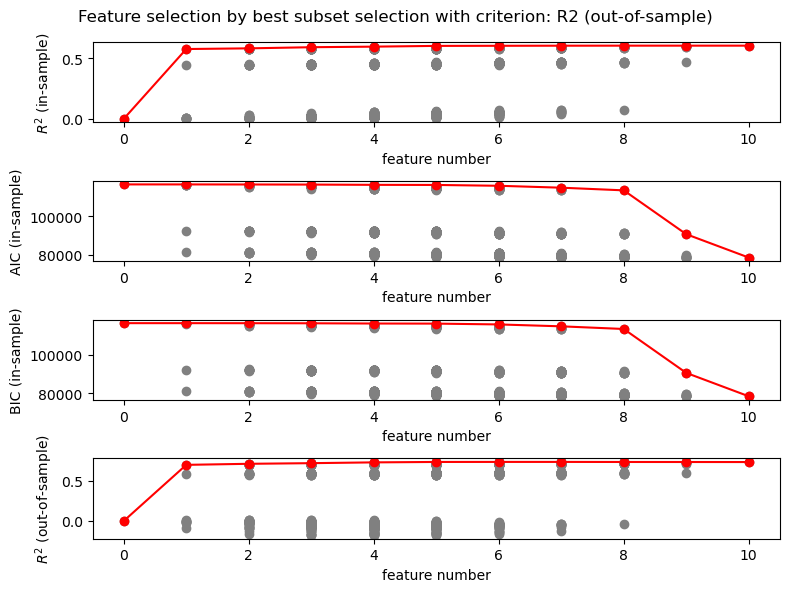

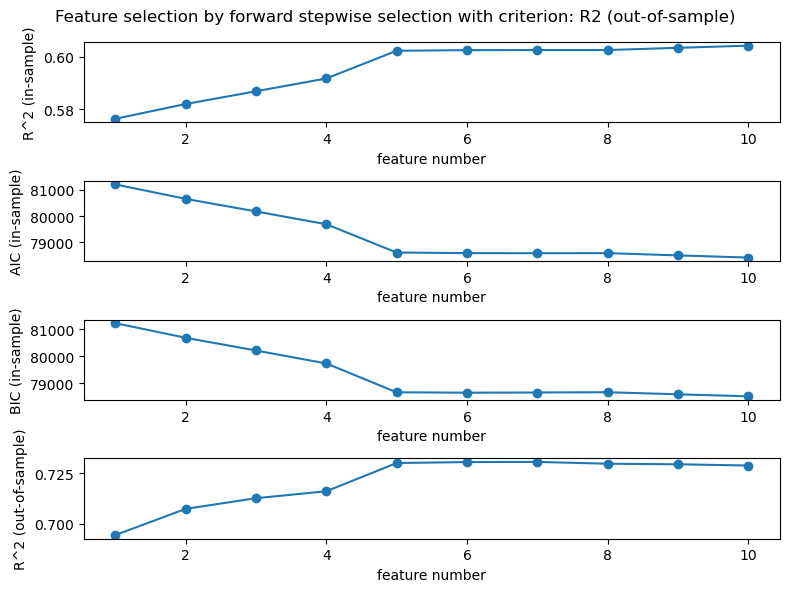

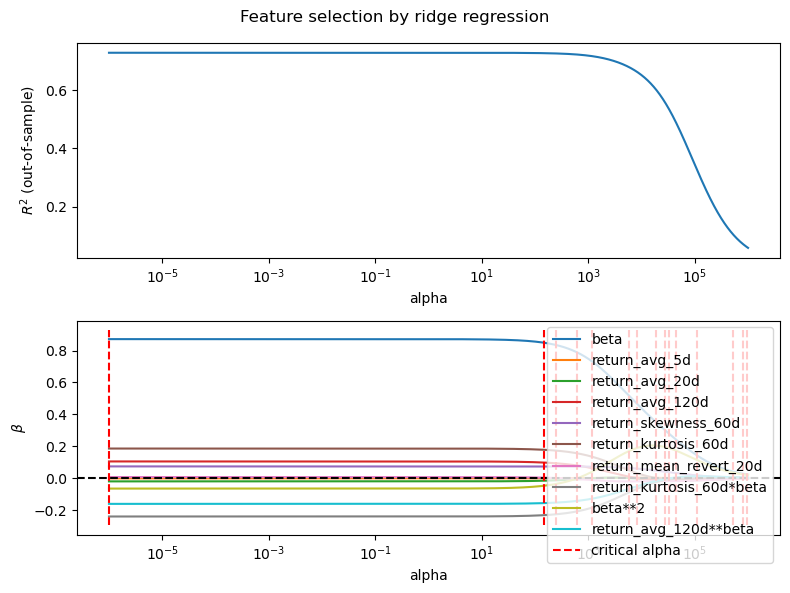

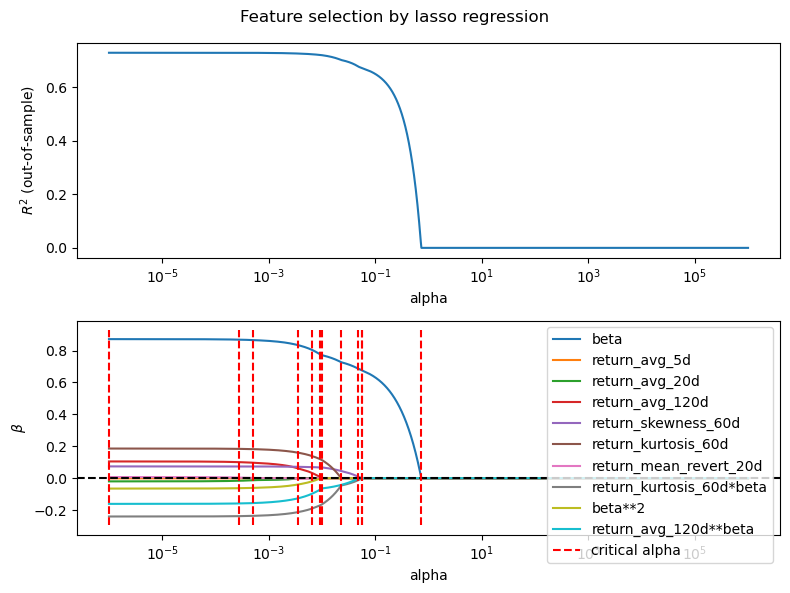

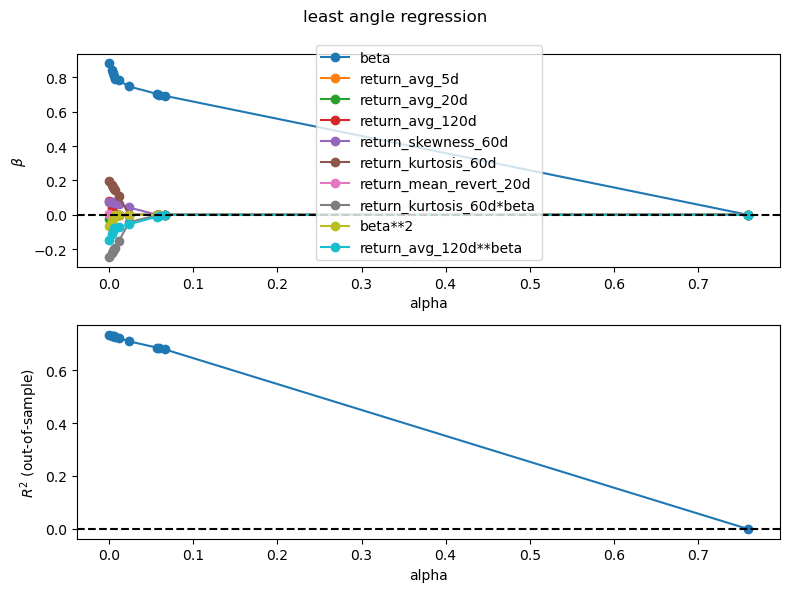

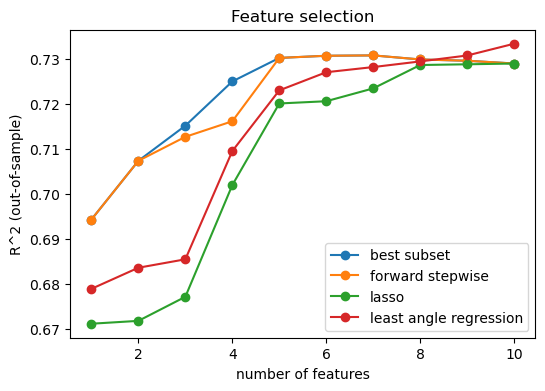

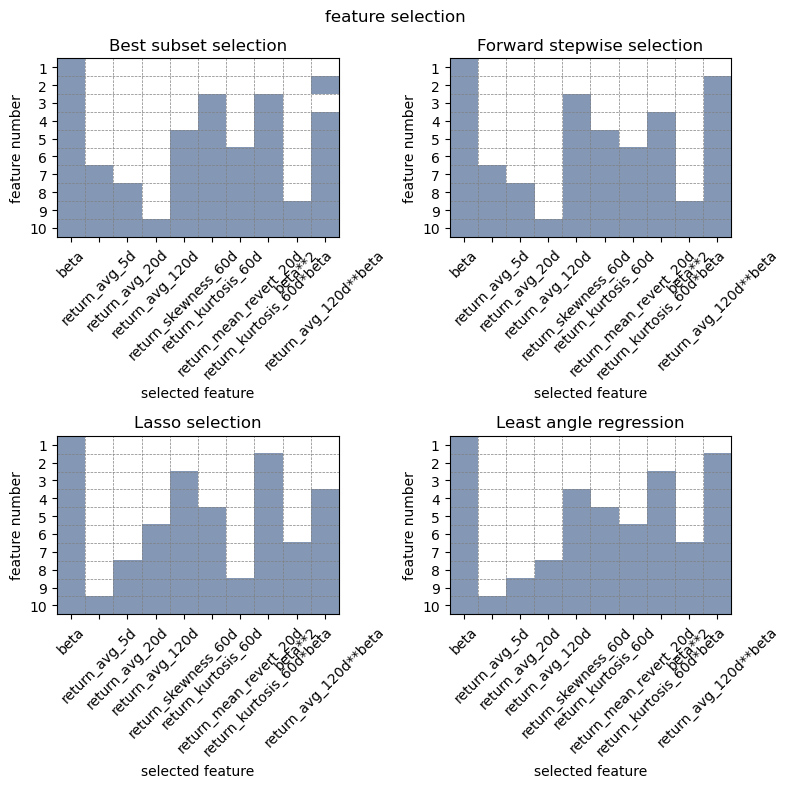

In [5]:
feature_dict["return_kurtosis_60d*beta"] = np.multiply(feature_dict["return_kurtosis_60d"], feature_dict["beta"])
feature_dict["beta**2"] = np.multiply(feature_dict["beta"], feature_dict["beta"])
feature_dict["return_avg_120d**beta"] = np.multiply(feature_dict["return_avg_120d"], feature_dict["beta"])

file_name = os.path.join(os.getcwd(), "../data/feature_dict.pkl")
with open(file_name, "wb") as f:
    pickle.dump(feature_dict, f)

feature_column = ["beta", 
                  "return_avg_5d", "return_avg_20d", "return_avg_120d", 
                  "return_skewness_60d", "return_kurtosis_60d", "return_mean_revert_20d",
                  "return_kurtosis_60d*beta", "beta**2", "return_avg_120d**beta"]

mse_model_add_nonlinear = utils.feature_selection_MSE(feature_column)

feature_validation = []
model = utils.linear_model_diagnosis(feature_column, year=2012, feature_selection=True)
feature_validation.append(model.feature_selection_best_subset_summary[5][0])


--- Feature selection by best subset ---
feature_num: 0, best feature: [], R^2 (in-sample): 0.0000, AIC (in-sample): 117892.0891, BIC (in-sample): 117900.7235, R^2 (out-of-sample): -0.0940
feature_num: 1, best feature: [0], R^2 (in-sample): 0.5300, AIC (in-sample): 86529.1429, BIC (in-sample): 86546.4118, R^2 (out-of-sample): 0.3124
feature_num: 2, best feature: [0, 2], R^2 (in-sample): 0.5309, AIC (in-sample): 86453.6224, BIC (in-sample): 86479.5258, R^2 (out-of-sample): 0.3165
feature_num: 3, best feature: [0, 5, 7], R^2 (in-sample): 0.5459, AIC (in-sample): 85101.1688, BIC (in-sample): 85135.7067, R^2 (out-of-sample): 0.3248
feature_num: 4, best feature: [0, 2, 5, 7], R^2 (in-sample): 0.5473, AIC (in-sample): 84976.2877, BIC (in-sample): 85019.4600, R^2 (out-of-sample): 0.3311
feature_num: 5, best feature: [0, 2, 5, 6, 7], R^2 (in-sample): 0.5476, AIC (in-sample): 84950.3706, BIC (in-sample): 85002.1773, R^2 (out-of-sample): 0.3322
feature_num: 6, best feature: [0, 2, 4, 5, 6, 7], R

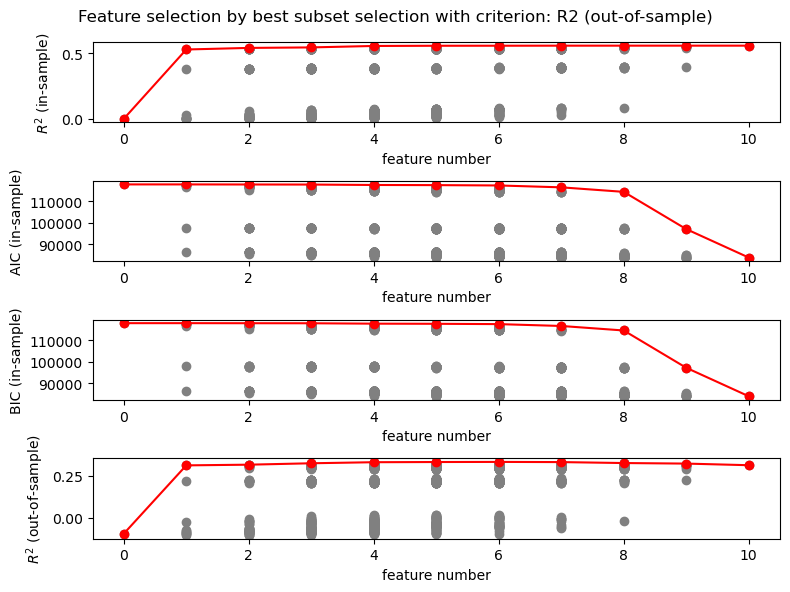

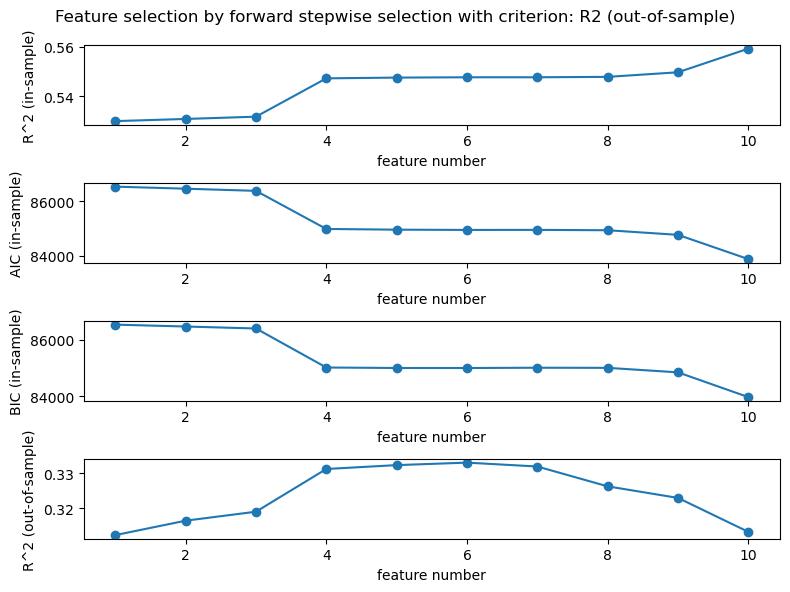

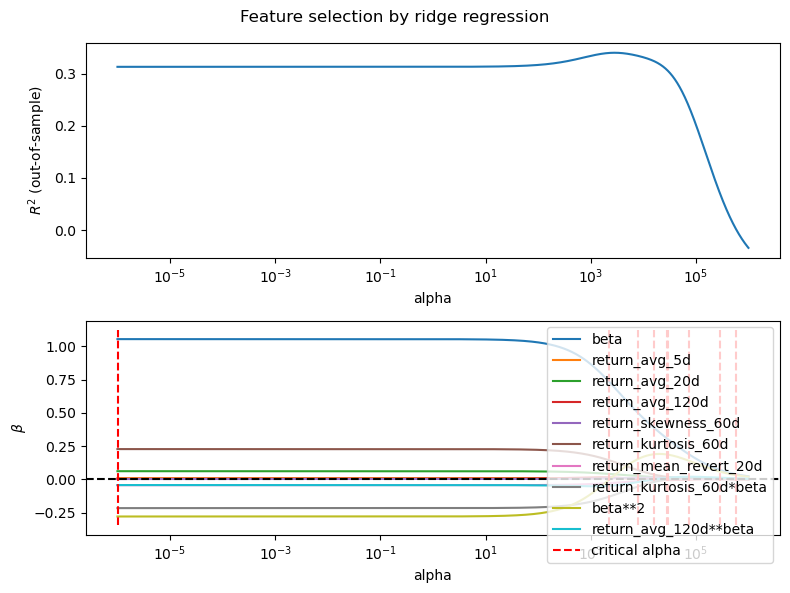

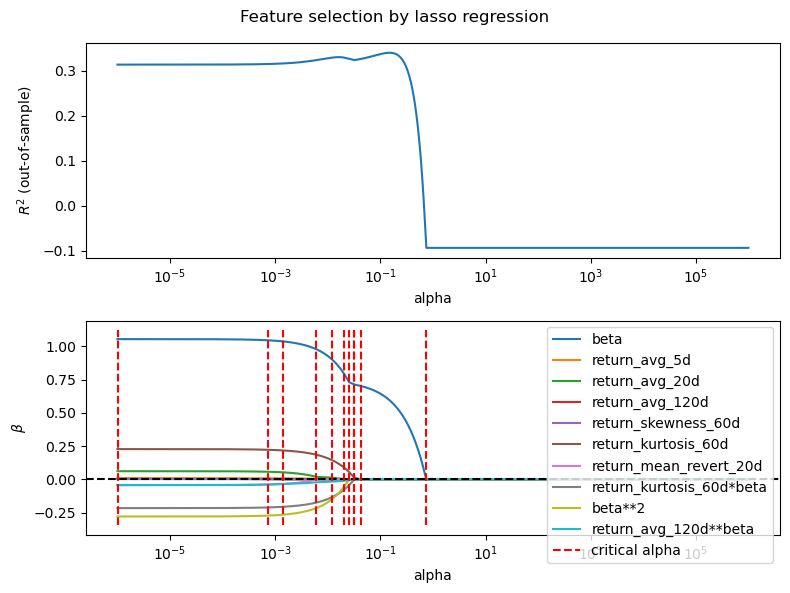

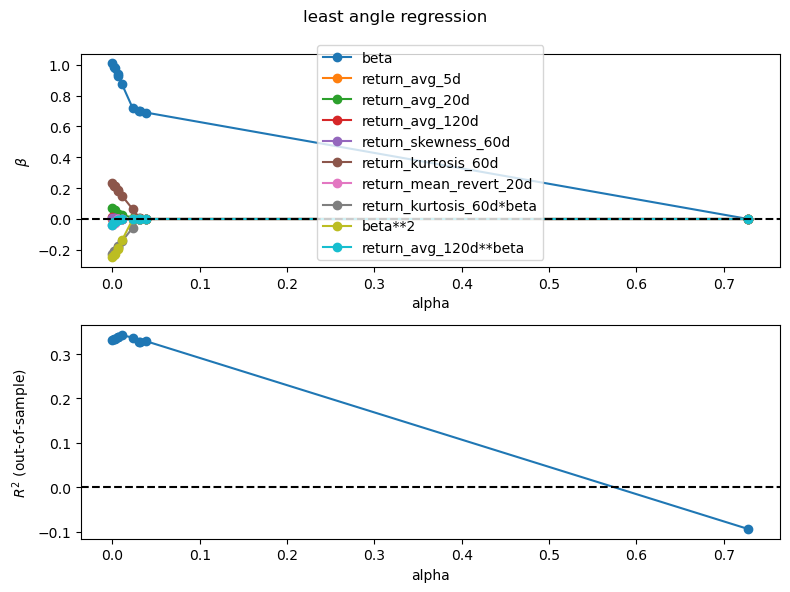

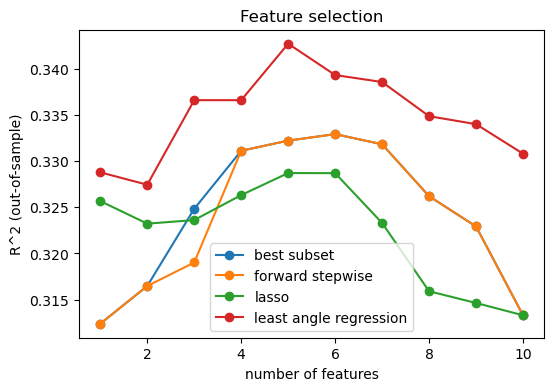

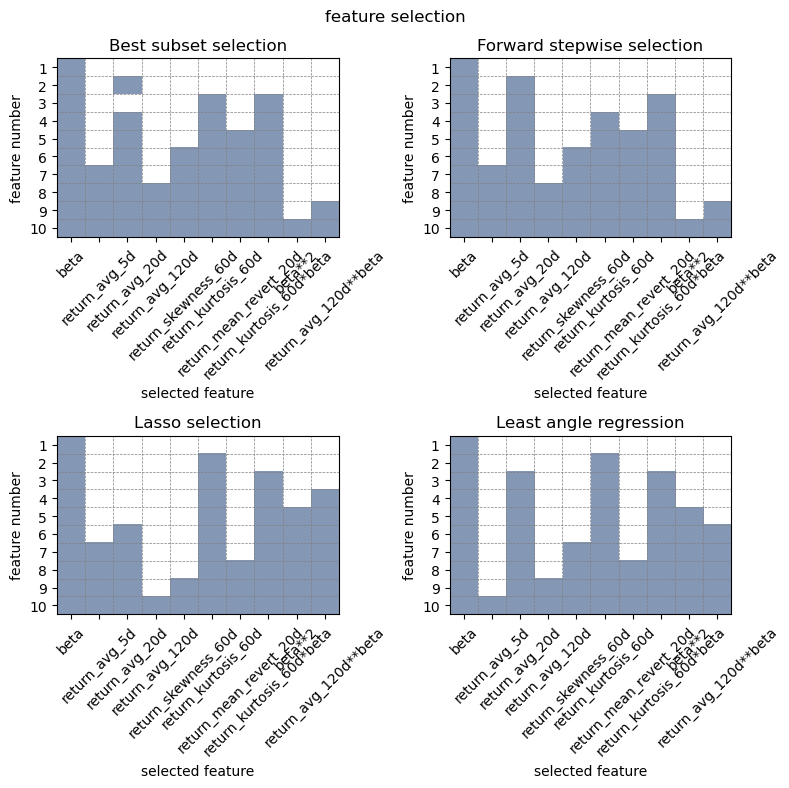

In [6]:
model = utils.linear_model_diagnosis(feature_column, year=2013, feature_selection=True)
feature_validation.append(model.feature_selection_least_angle_regression_summary[5][0])


--- Feature selection by best subset ---
feature_num: 0, best feature: [], R^2 (in-sample): -0.0000, AIC (in-sample): 122322.0152, BIC (in-sample): 122330.6865, R^2 (out-of-sample): -0.0136
feature_num: 1, best feature: [0], R^2 (in-sample): 0.4152, AIC (in-sample): 99198.3308, BIC (in-sample): 99215.6735, R^2 (out-of-sample): 0.3868
feature_num: 2, best feature: [0, 8], R^2 (in-sample): 0.4271, AIC (in-sample): 98314.7763, BIC (in-sample): 98340.7904, R^2 (out-of-sample): 0.4113
feature_num: 3, best feature: [0, 3, 9], R^2 (in-sample): 0.4755, AIC (in-sample): 94514.6665, BIC (in-sample): 94549.3519, R^2 (out-of-sample): 0.4402
feature_num: 4, best feature: [0, 3, 7, 9], R^2 (in-sample): 0.4782, AIC (in-sample): 94293.1089, BIC (in-sample): 94336.4656, R^2 (out-of-sample): 0.4398
feature_num: 5, best feature: [0, 3, 5, 7, 9], R^2 (in-sample): 0.4814, AIC (in-sample): 94030.3160, BIC (in-sample): 94082.3441, R^2 (out-of-sample): 0.4472
feature_num: 6, best feature: [0, 3, 4, 5, 7, 9], 

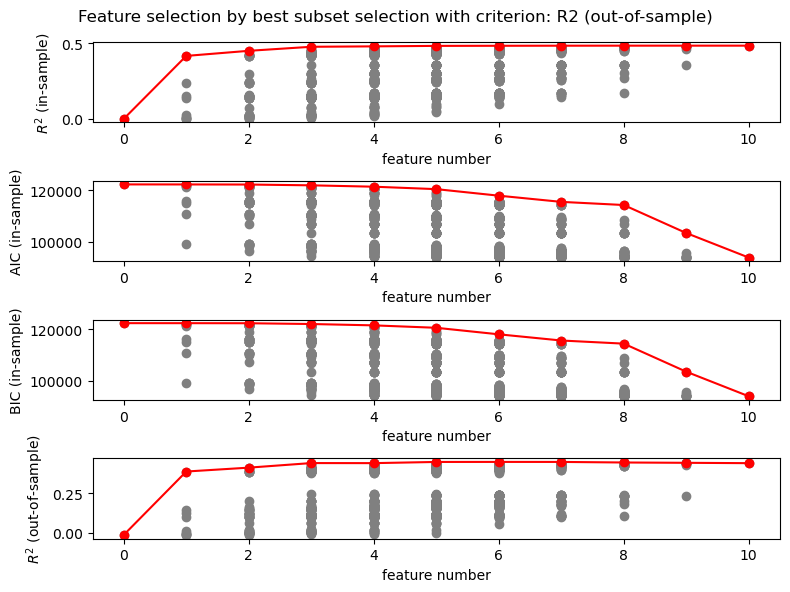

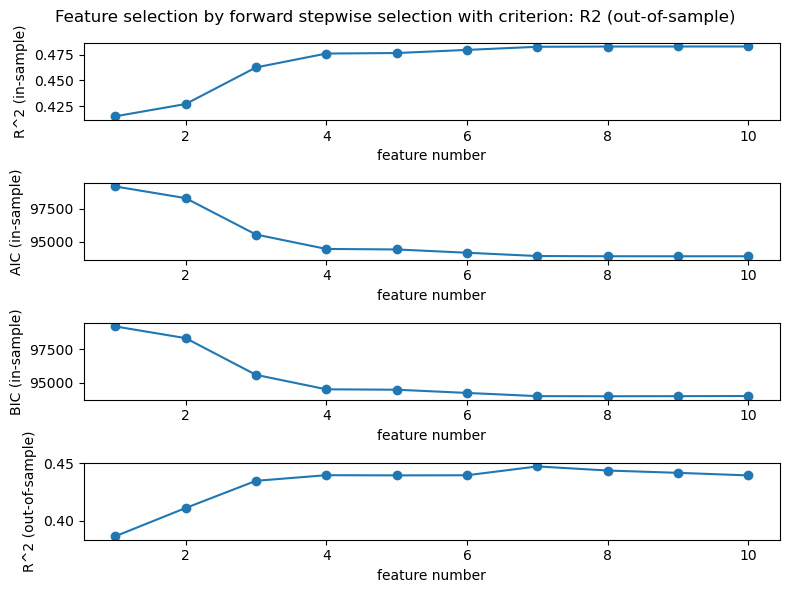

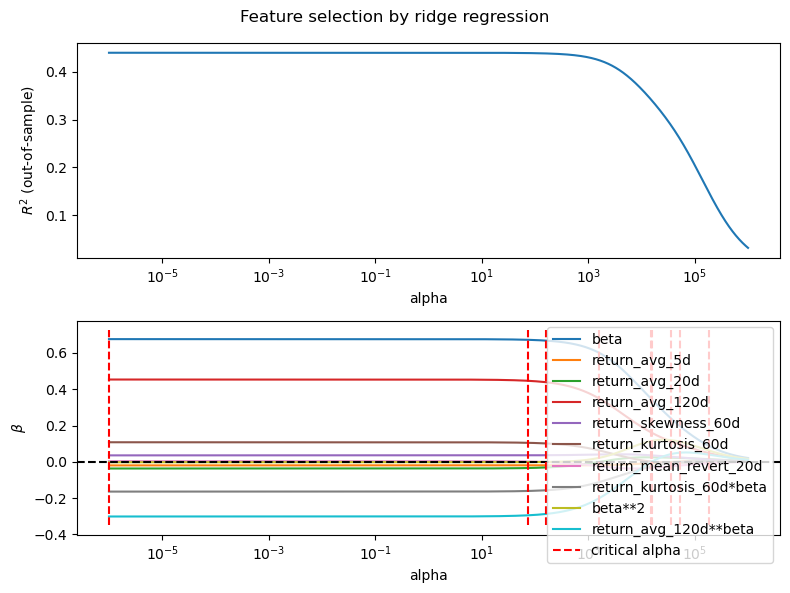

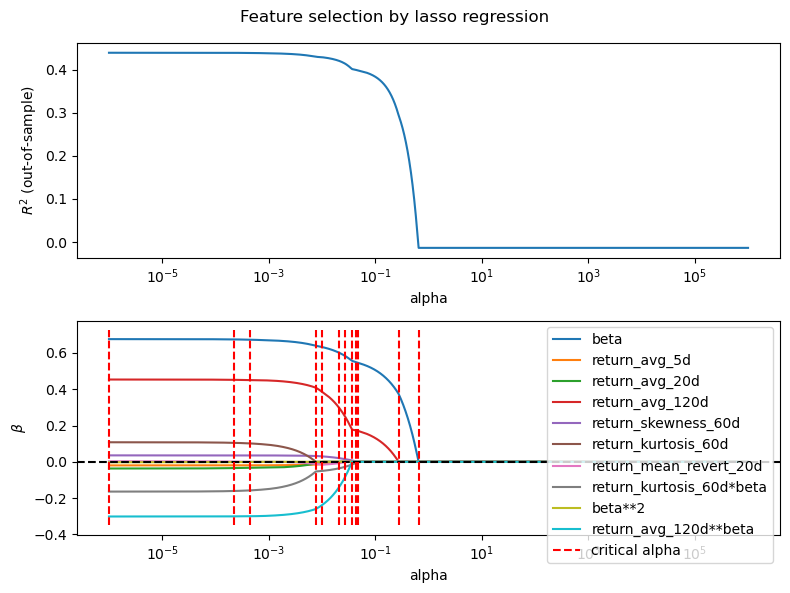

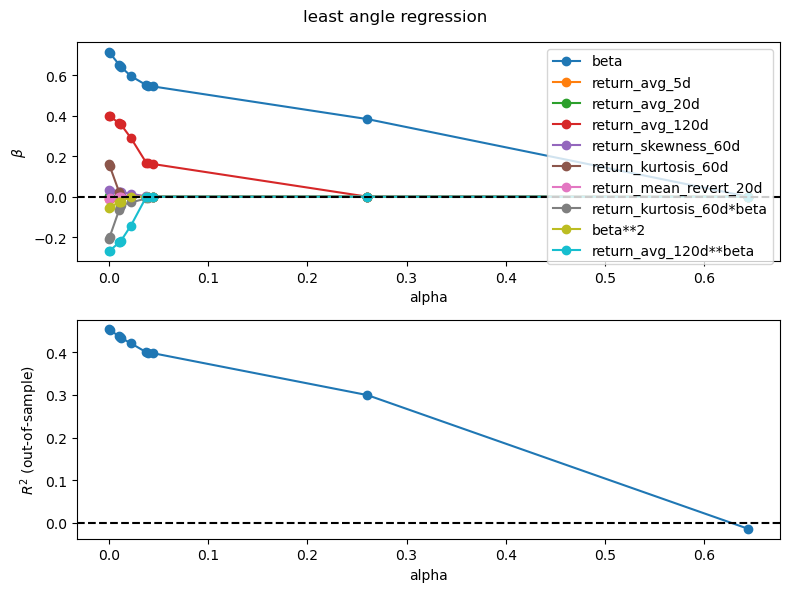

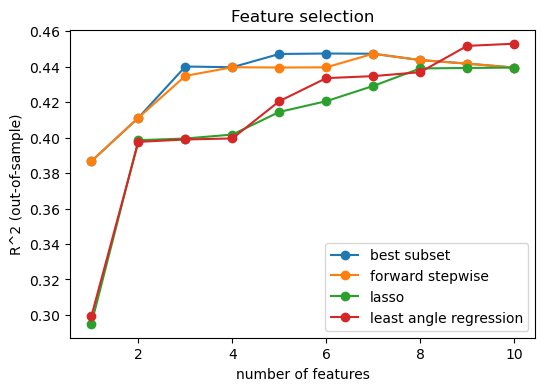

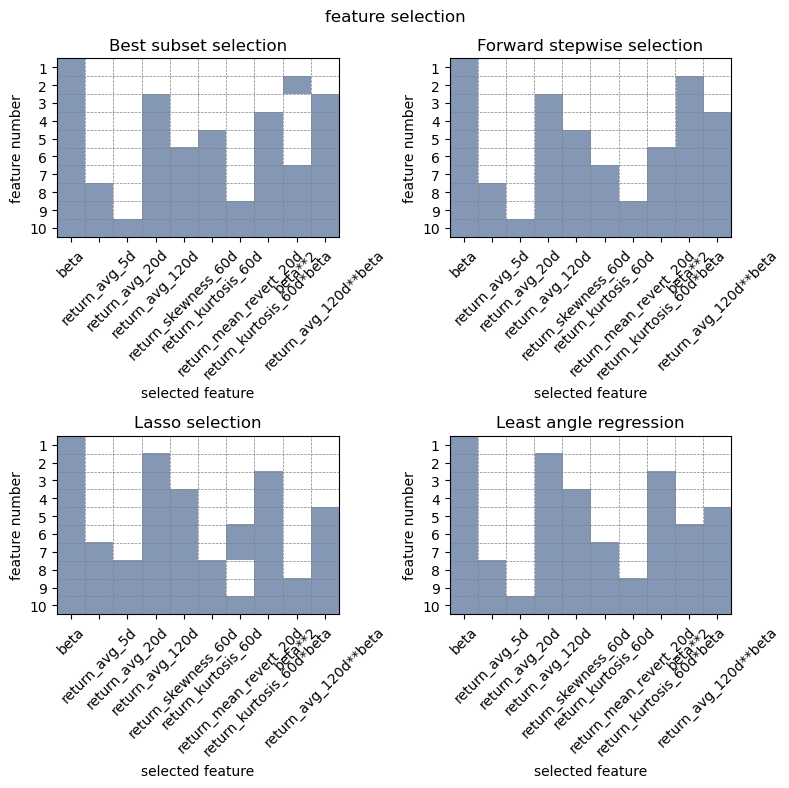

In [7]:
model = utils.linear_model_diagnosis(feature_column, year=2014, feature_selection=True)
feature_validation.append(model.feature_selection_best_subset_summary[5][0])



--- Feature selection by best subset ---
feature_num: 0, best feature: [], R^2 (in-sample): 0.0000, AIC (in-sample): 114866.9121, BIC (in-sample): 114875.5206, R^2 (out-of-sample): -0.0329
feature_num: 1, best feature: [0], R^2 (in-sample): 0.4456, AIC (in-sample): 90995.6724, BIC (in-sample): 91012.8893, R^2 (out-of-sample): 0.4800
feature_num: 2, best feature: [0, 8], R^2 (in-sample): 0.4670, AIC (in-sample): 89400.5926, BIC (in-sample): 89426.4180, R^2 (out-of-sample): 0.5463
feature_num: 3, best feature: [0, 6, 8], R^2 (in-sample): 0.4716, AIC (in-sample): 89051.2902, BIC (in-sample): 89085.7241, R^2 (out-of-sample): 0.5589
feature_num: 4, best feature: [0, 1, 6, 8], R^2 (in-sample): 0.4718, AIC (in-sample): 89040.2253, BIC (in-sample): 89083.2677, R^2 (out-of-sample): 0.5594
feature_num: 5, best feature: [0, 5, 6, 7, 8], R^2 (in-sample): 0.4845, AIC (in-sample): 88057.8045, BIC (in-sample): 88109.4552, R^2 (out-of-sample): 0.5640
feature_num: 6, best feature: [0, 1, 5, 6, 7, 8], R

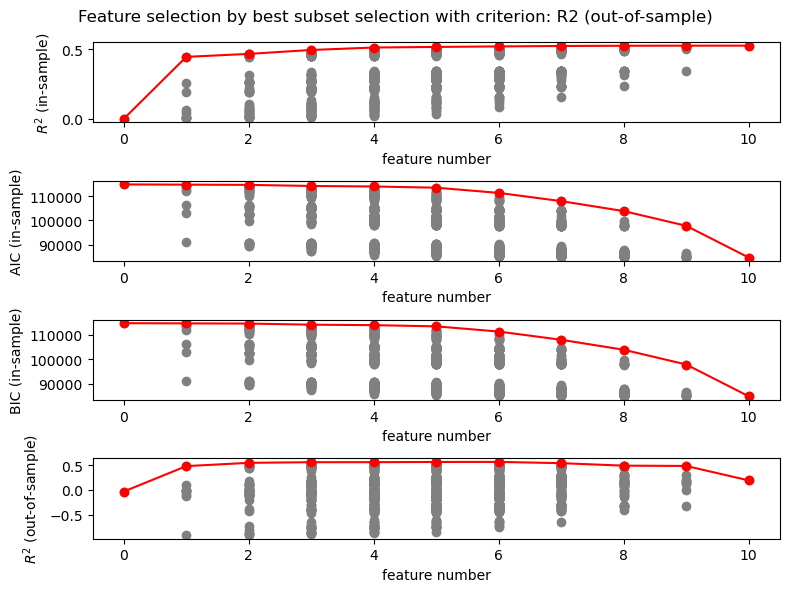

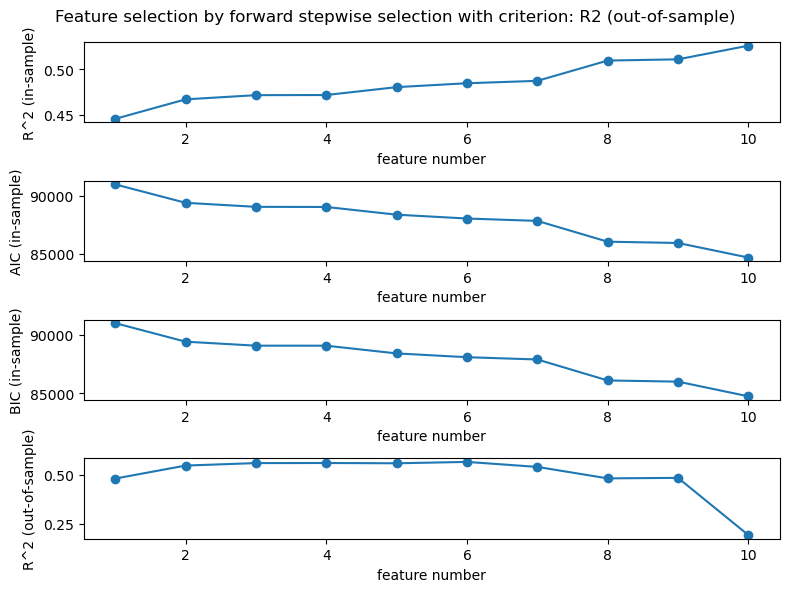

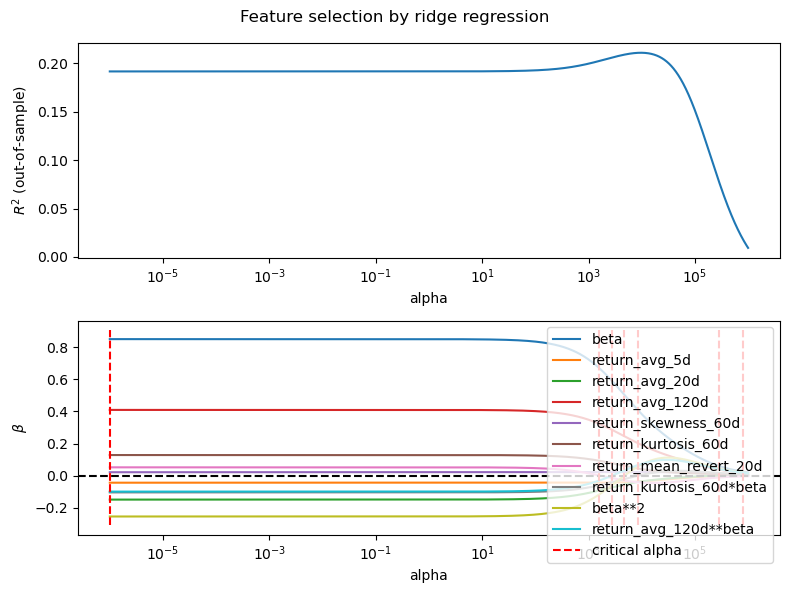

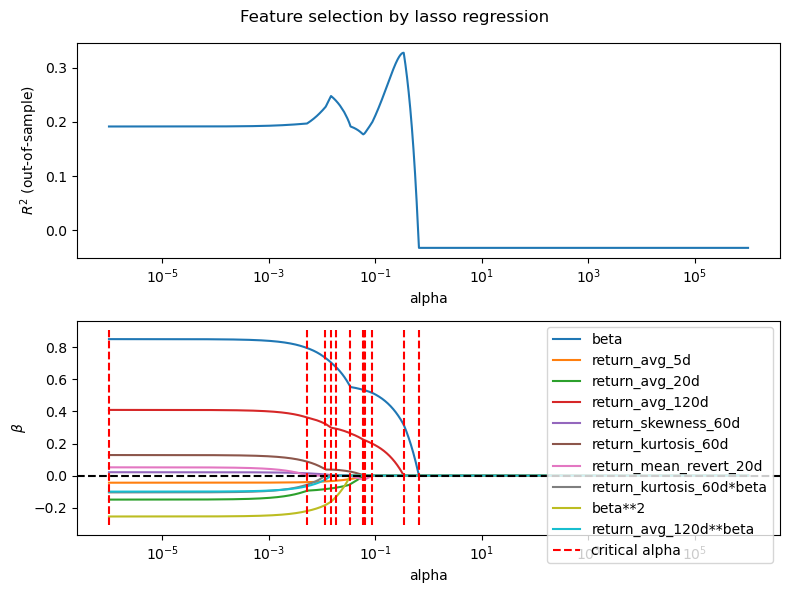

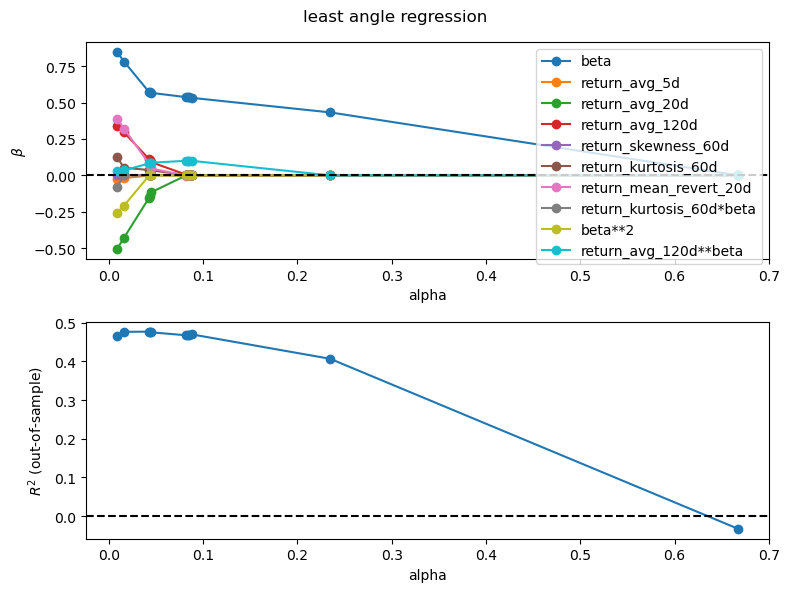

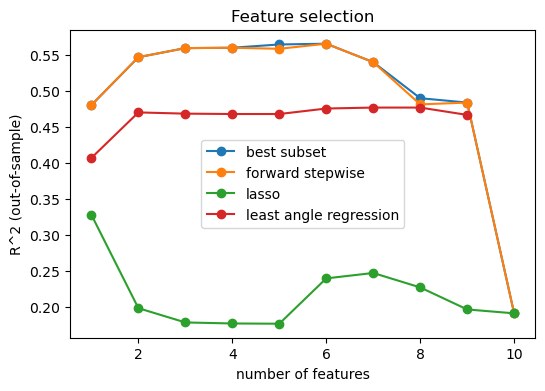

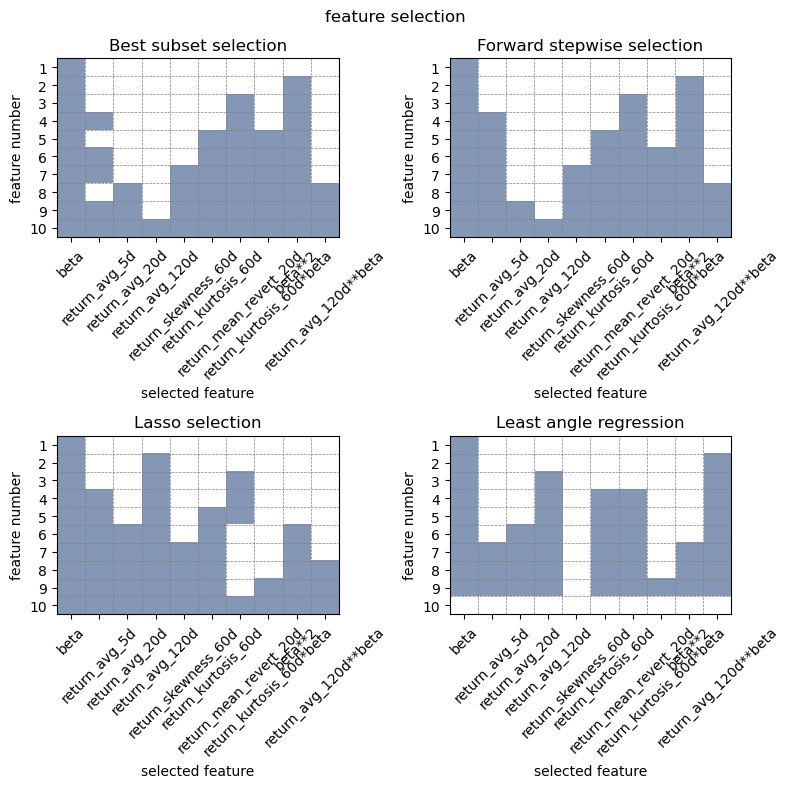

In [8]:
model = utils.linear_model_diagnosis(feature_column, year=2015, feature_selection=True)
feature_validation.append(model.feature_selection_best_subset_summary[5][0])